In [1]:
import pandas as pd
final_dataset = pd.read_csv('data_analysis/final_dataset.csv')
print(final_dataset.head())
print(final_dataset.columns)


   user_id  movie_id_ml  rating     rating_timestamp  \
0      186          302       3  1998-04-04 19:22:22   
1      186         1042       5  1997-11-08 21:13:52   
2      186           98       5  1998-04-04 19:57:39   
3      186          327       3  1998-04-04 19:23:26   
4      186          332       4  1998-04-04 19:56:15   

                      title  release  \
0         l.a. confidential     1997   
1                just cause     1995   
2  the silence of the lambs     1991   
3                  cop land     1997   
4            kiss the girls     1997   

                                                 url  unknown  action  \
0  http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...        0       0   
1  http://us.imdb.com/M/title-exact?Just%20Cause%...        0       0   
2  http://us.imdb.com/M/title-exact?Silence%20of%...        0       0   
3   http://us.imdb.com/M/title-exact?Cop+Land+(1997)        0       0   
4  http://us.imdb.com/M/title-exact?Kiss+the+Girl...     

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.accuracy import rmse
from sklearn.metrics import ndcg_score
from surprise.model_selection import cross_validate
import json

# Load the dataset
df = pd.read_csv("data_analysis/final_dataset.csv", low_memory=False)

# Combine separate genre columns into a single 'genres' column
genre_columns = ['unknown', 'action', 'adventure', 'animation', 'childrens', 'comedy',
                 'crime', 'documentary', 'drama', 'fantasy', 'noir', 'horror',
                 'musical', 'mystery', 'romance', 'scifi', 'thriller', 'war', 'western']

df['genres'] = df[genre_columns].apply(lambda row: ', '.join([genre for genre, value in row.items() if value == 1]), axis=1)

# Step 1: Filter users with more than 200 interactions
user_interactions = df.groupby('user_id').size()
active_users = user_interactions[user_interactions > 200].index
df = df[df['user_id'].isin(active_users)]

#extract cast names
def extract_cast_names(cast_column):
    try:
        cast_list = json.loads(cast_column.replace("'", '"'))  # Convert string to JSON
        return ', '.join([person['cast_name'] for person in cast_list if 'cast_name' in person])
    except (json.JSONDecodeError, TypeError):
        return ''  # Return empty string if parsing fails

df['cast'] = df['cast'].apply(extract_cast_names)
df['cast'] = df['cast'].fillna("Cast not available")
df = df[df['cast'].str.strip() != '']  # Drop rows where 'cast' is an empty string or contains only whitespace
df.dropna(subset=['cast'], inplace=True)  # Drop rows where 'cast' is NaN


# Step 2: Filter ratings as 1 if > 2.5 else 0
df['rating'] = df['rating'].apply(lambda x: 1 if x > 2.5 else 0)

# Step 3: Drop NaN values
df.dropna(inplace=True)

# Step 4: Prepare data for SVD
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df[['user_id', 'movie_id_ml', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)


# Initialize the SVD model
model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)

# Perform cross-validation
print("Performing cross-validation...")
cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

model.fit(trainset)

# Predict on the test set
predictions = model.test(testset)

# Calculate RMSE
rmse_value = rmse(predictions, verbose=True)

# Precision@k and NDCG
# Convert predictions into a DataFrame for precision and NDCG evaluation
test_df = pd.DataFrame([(pred.uid, pred.iid, pred.est, pred.r_ui) for pred in predictions], 
                       columns=['user_id', 'movie_id_ml', 'predicted', 'actual'])
test_df = test_df.sort_values(by=['user_id', 'predicted'], ascending=[True, False])

def precision_at_k(df, k=5):
    precisions = []
    for user, group in df.groupby('user_id'):
        top_k = group.head(k)
        precision = top_k[top_k['actual'] == 1].shape[0] / k
        precisions.append(precision)
    return np.mean(precisions)

def ndcg_at_k(df, k=5):
    ndcgs = []
    for user, group in df.groupby('user_id'):
        top_k = group.head(k)
        actual = np.array(top_k['actual'])
        predicted = np.array(top_k['predicted'])
        ndcgs.append(ndcg_score([actual], [predicted]))
    return np.mean(ndcgs)

precision_k = precision_at_k(test_df, k=5)
ndcg_k = ndcg_at_k(test_df, k=5)

print(f"Precision@k: {precision_k}")
print(f"NDCG@k: {ndcg_k}")

# Step 5: Recommendations for a test user
test_user_id = test_df['user_id'].sample(1).iloc[0]
# Output for Previous Movies Rated by the User
test_user_movies = df[df['user_id'] == test_user_id][['title', 'rating', 'genres', 'cast', 'keyword', 'director']]

# Get top N recommendations
def get_top_n_recommendations(model, user_id, n=3):
    user_movies = df['movie_id_ml'].unique()
    user_rated_movies = df[df['user_id'] == user_id]['movie_id_ml'].unique()
    candidates = [movie for movie in user_movies if movie not in user_rated_movies]
    predictions = [model.predict(user_id, movie) for movie in candidates]
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return [(pred.iid, pred.est) for pred in top_n]
    
# Generate Top N Recommendations
unique_recommendations = get_top_n_recommendations(model, test_user_id, n=3)
recommended_movies = (
    df[df['movie_id_ml'].isin([rec[0] for rec in unique_recommendations])]
    [['title', 'genres', 'cast', 'keyword', 'director']]
    .drop_duplicates(subset='title')  # Drop duplicates based on title
    .head(3)  # Select the top 3 unique recommendations
)

# Output results
print(f"Test User ID: {test_user_id}")
print("Previous Movies Rated by the User (Random 10):")
random_sample_movies = test_user_movies.sample(n=min(10, len(test_user_movies)), random_state=42)
print(random_sample_movies)

print("\nTop 3 Recommendations:")
print(recommended_movies)



Performing cross-validation...
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3470  0.3507  0.3492  0.3470  0.3386  0.3465  0.0042  
Fit time          0.03    0.04    0.03    0.03    0.03    0.03    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    
RMSE: 0.3522
Precision@k: 0.9395833333333332
NDCG@k: 0.9822370157178092
Test User ID: 416
Previous Movies Rated by the User (Random 10):
                                    title  rating  \
21527                           lone star       1   
21351  indiana jones and the last crusade       1   
21587                        tom and huck       1   
21247                               mimic       1   
21475                      poetic justice       1   
21230              the sword in the stone       1   
21412     snow white and the seven dwarfs       1   
21298                            clueless       1   
21423 

[('horror_1 <= 0.00', 0.0568932776532751), ('fantasy_1 <= 0.00', 0.05128080546038217), ('mystery_1 > 0.00', 0.04697560731378137), ('adventure_1 <= 0.00', -0.03292090387158682), ('noir_1 > 0.00', 0.032296846700506185), ('childrens_1 <= 0.00', 0.031013144564705945), ('crime_1 > 0.00', 0.02927578053756917), ('musical_1 <= 0.00', -0.0282288917175372), ('comedy_1 <= 0.00', 0.027021824551792865), ('war_1 <= 0.00', -0.026861038356967376)]


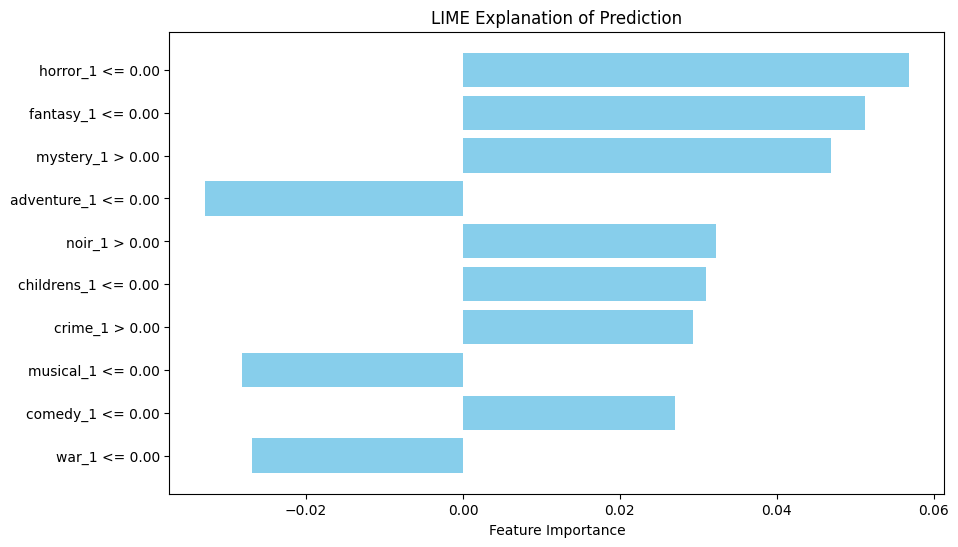

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt


# Encode categorical features (genres, director, etc.)
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter
encoded_genres = encoder.fit_transform(df[genre_columns])
label_encoder = LabelEncoder()
encoded_directors = label_encoder.fit_transform(df['director']).reshape(-1, 1)

# Combine all features into a single array
X = np.hstack([encoded_genres, encoded_directors])
y = df['rating'].values

# Create feature names
genre_feature_names = encoder.get_feature_names_out(genre_columns)
director_feature_name = ['director_' + str(label) for label in label_encoder.classes_]
feature_names = list(genre_feature_names) + director_feature_name

# Train a simple model
model = LinearRegression()
model.fit(X, y)

# Prediction function for LIME
def predict_fn(data):
    return model.predict(data)

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X,
    training_labels=y,
    feature_names=feature_names,
    mode='regression'
)

# Explain a specific prediction
test_instance = X[0].reshape(1, -1)  # Select a single row for explanation
exp = explainer.explain_instance(
    data_row=test_instance[0],
    predict_fn=predict_fn
)

# Print explanation
print(exp.as_list())

explanation = exp.as_list()  # This is the explanation from the LIME explainer
features, importance = zip(*explanation)  # Unzip the feature names and importance scores

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(features, importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('LIME Explanation of Prediction')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [6]:
# Combine all features for explanation
genre_encoded_columns = encoder.get_feature_names_out(genre_columns)
feature_names = list(genre_encoded_columns) + ['director']

# Check the length of feature_names
print(f"Number of features: {X.shape[1]}, Feature names: {len(feature_names)}")

if len(feature_names) != X.shape[1]:
    raise ValueError("Mismatch between feature names and training data columns.")

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X,
    training_labels=y,
    feature_names=feature_names,
    mode='regression'  # Change to 'classification' for binary classification
)


Number of features: 38, Feature names: 38


In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

# Example of one-hot encoding for 'genres', 'cast', and other categorical columns
def one_hot_encode(df, column):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[column].str.split(', '))
    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
    return encoded_df

# Apply one-hot encoding to the relevant categorical columns
df_encoded = pd.concat([
    df.drop(columns=['genres', 'cast', 'director', 'keyword']),  # Drop the original categorical columns
    one_hot_encode(df, 'genres'),
    one_hot_encode(df, 'cast'),
    one_hot_encode(df, 'director'),
    one_hot_encode(df, 'keyword')
], axis=1)

# Now df_encoded has numerical data that can be passed to the LIME explainer


LIME

In [33]:
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import lime
from surprise import SVD
from sklearn.decomposition import PCA

# Drop non-numeric columns like 'rating_timestamp' and 'title' from df_encoded
df_encoded = df_encoded.drop(columns=['rating_timestamp', 'title'])

# Ensure all remaining columns are numeric
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values after coercion
df_encoded = df_encoded.dropna()

# Feature columns after encoding (excluding non-numeric columns)
feature_columns = list(df_encoded.columns.difference(['rating', 'user_id', 'movie_id_ml']))

# Take a subset of the data to avoid memory overflow
df_subset = df_encoded.sample(n=5000, random_state=42)  # Adjust the number of samples as needed
X_train, X_test, y_train, y_test = train_test_split(df_subset[feature_columns], df_subset['rating'], test_size=0.2, random_state=42)

# Apply PCA for dimensionality reduction (e.g., reducing to 50 components)
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize LIME Explainer with the reduced features
explainer = LimeTabularExplainer(
    training_data=X_train_pca,
    training_labels=y_train.values,
    mode="classification",
    feature_names=[f"PC{i}" for i in range(1, 51)],  # Use principal components as feature names
    class_names=[0, 1],
    discretize_continuous=True
)

# Now, use the model and generate explanations using LIME
def predict_function(user_movie_data):
    # For each movie in the user_movie_data, predict the ratings using the model
    predictions = [model.predict(uid=int(user_movie_data[0]), iid=int(movie_id)) for movie_id in user_movie_data[1:]]
    # Return the predicted ratings
    return np.array([pred.est for pred in predictions])

# Select a random test user (or your recommended user)
recommended_movie_id = recommended_movies['title'].iloc[0]  # Adjust as needed

# Get the features for the recommended movie using one-hot encoding
recommended_movie_features = df_encoded[df_encoded['title'] == recommended_movie_id][feature_columns].values[0]

# Generate explanation for the recommended movie using LIME
lime_explanation = explainer.explain_instance(recommended_movie_features, predict_function, num_features=5)

# Show the explanation
lime_explanation.show_in_notebook()


ValueError: a must be greater than 0 unless no samples are taken

In [35]:
print(df.head())  # Check the first few rows to see the structure of the data
print(df.isna().sum())  # Check how many NaN values are present in each column



     user_id  movie_id_ml  rating     rating_timestamp  \
768      303          302       1  1997-11-14 00:06:26   
771      303          222       1  1997-11-14 00:46:54   
773      303          387       1  1997-11-14 05:30:01   
776      303          277       1  1997-11-14 00:49:07   
782      303          603       1  1997-11-14 00:14:17   

                        title  release  \
768         l.a. confidential     1997   
771  star trek: first contact     1996   
773      the age of innocence     1993   
776               restoration     1995   
782               rear window     1954   

                                                   url  unknown  action  \
768  http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...        0       0   
771  http://us.imdb.com/M/title-exact?Star%20Trek:%...        0       1   
773  http://us.imdb.com/M/title-exact?Age%20of%20In...        0       0   
776  http://us.imdb.com/M/title-exact?Restoration%2...        0       0   
782  http://us.imdb.com

In [27]:
# Get the total number of rows in the DataFrame
total_rows = len(df)

# Count the number of rows with an empty cast
empty_cast_count = df[df['cast'].str.strip() == ''].shape[0]

# Print the result
print(f"Number of rows with an empty cast: {empty_cast_count} out of {total_rows} total rows")


Number of rows with an empty cast: 0 out of 9988 total rows


In [ ]:
import sys
import pandas as pd

# Prevent truncation of DataFrame content
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the line width for display
pd.set_option('display.max_colwidth', None)  # Ensure no truncation of cell content

# File to save output
output_file = "recommendation_output.txt"

# Redirect standard output to a file
with open(output_file, "w") as file:
    sys.stdout = file  # Redirect stdout to file
    
    # Your existing code
    print(f"Precision@k: {precision_k}")
    print(f"NDCG@k: {ndcg_k}")
    
    print(f"Test User ID: {test_user_id}")
    print("Previous Movies Rated by the User:")
    print(test_user_movies)
    
    print("\nTop 3 Recommendations:")
    print(recommended_movies)
    
# Restore standard output
sys.stdout = sys.__stdout__

print(f"Output has been written to {output_file}")


OLD RS

In [1]:
import pandas as pd
import random
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Load the ratings data
ratings = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

# Load the movies data
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None,
                     names=['item_id', 'title'] + [f'genre_{i}' for i in range(19)])

# Load the user data
users = pd.read_csv('ml-100k/u.user', sep='|', header=None, 
                    names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

genres = [
    "Unknown",
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western"
]


user_interactions = ratings.groupby('user_id').size()
user_indexes = user_interactions[user_interactions > 200].index 
ratings = ratings[ratings.user_id.isin(user_indexes)]
ratings.rating = [1 if rating > 2.5 else 0 for rating in ratings.rating]
ratings

movies = movies[movies.index.get_level_values(0).isin(ratings.item_id)]
movies = movies.dropna(axis=1)
movies.columns = genres
movies["Title"] = movies.index.get_level_values(1)
movies


# Select a random user for recommendation
test_user = random.choice(ratings.user_id.unique())

# Prepare the dataset for collaborative filtering (using SVD)
reader = Reader(rating_scale=(0, 1))  # Updated rating scale for binarized ratings
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

# Initialize and train the SVD model
svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005)
svd.fit(trainset)

# Make predictions on the test set
predictions = svd.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE on test set: {rmse}")

# Function to get top-N recommendations
def get_top_n(predictions, n=10):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))
    
    # Sort the predictions for each user and retrieve the N highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

# Get top-3 recommendations for the selected user
top_n = get_top_n(predictions, n=3)

# Display recommendations for the selected user
print(f"\nTop-N Recommendations for User {test_user}:")
for uid, user_ratings in top_n.items():
    if uid == test_user:
        for iid, rating in user_ratings:
            if iid in movies.index:  # Ensure item_id is used as the index
                movie_data = movies.loc[iid]  # Fetch row by item_id
                movie_title = movie_data['Title']
                
                # Fetch genre columns as a series or row
                genre_values = movie_data[genres].values.flatten()  # Flatten to ensure it's a 1D array
                genres_list = [genre for genre, g in zip(genres, genre_values) if g == 1]
                
                print(f"\tItem {iid}: {movie_title} with predicted rating {rating:.2f} | Genres: {', '.join(genres_list)}")
            else:
                print(f"\tItem {iid} (Movie data not available) with predicted rating {rating:.2f}")

# Display previously rated movies for the selected user
user_ratings = ratings[ratings['user_id'] == test_user]
print(f"\nPreviously Rated Items by User {test_user}:")
for _, row in user_ratings.iterrows():
    iid = row['item_id']
    if iid in movies.index:  # Use the index to check if the movie exists
        movie_data = movies.loc[iid]
        movie_title = movie_data['Title'].values[0]
        genre_values = movie_data.iloc[0][genres].values 
        genres_list = [genre for genre, g in zip(genres, genre_values) if g == 1]
        print(f"\tItem {iid}: {movie_title} with rating {row['rating']} | Genres: {', '.join(genres_list)}")
    else:
        print(f"\tItem {iid} (Movie data not available) with rating {row['rating']}")


ModuleNotFoundError: No module named 'pandas'